In [1]:
#imports

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-07-28 10:50:26.419652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 10:50:26.419765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 10:50:26.555964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#seed for stable results
seed = 7

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
!unzip -qq ../input/dogs-vs-cats/test1.zip -d ../working
!unzip -qq ../input/dogs-vs-cats/train.zip -d ../working

!mkdir ../working/train/dog
!mkdir ../working/train/cat

!cd ../working/train ; ls  | grep "cat.*.jpg" | xargs mv -t cat/
!cd ../working/train ; ls  | grep "dog.*.jpg" | xargs mv -t dog/

!ls -l ../working/train/dog | wc -l
!ls -l ../working/train/cat | wc -l

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


12501
12501


In [5]:
directory = "../working/train"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.8,
                                             subset='training',
                                             seed=seed)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [6]:
train_dataset.class_names

['cat', 'dog']

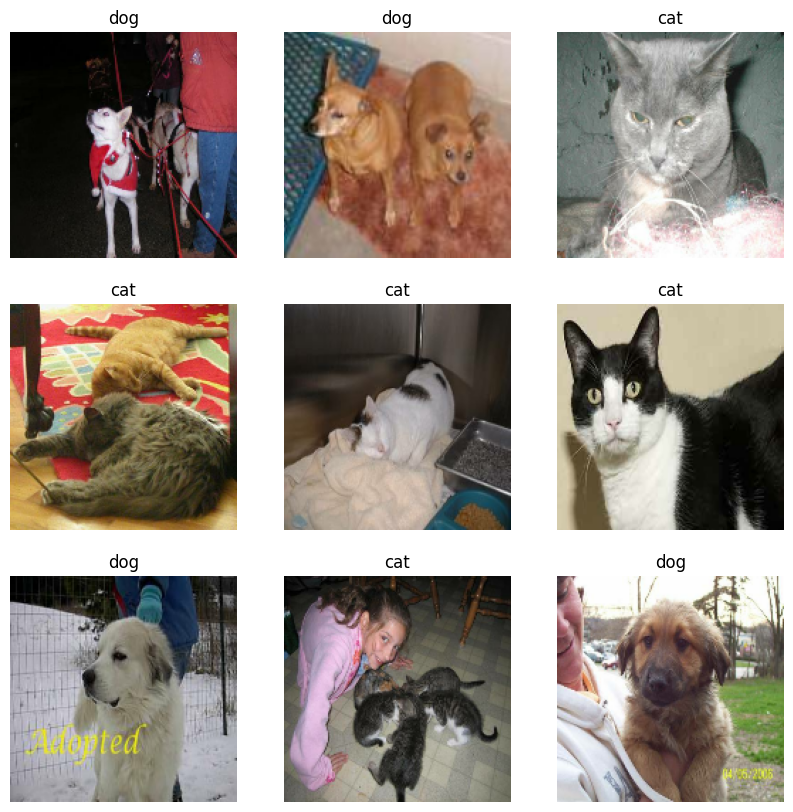

In [7]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
#prefetching settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tfl.RandomFlip('horizontal'))
    data_augmentation.add(tfl.RandomRotation(0.2))
    return data_augmentation

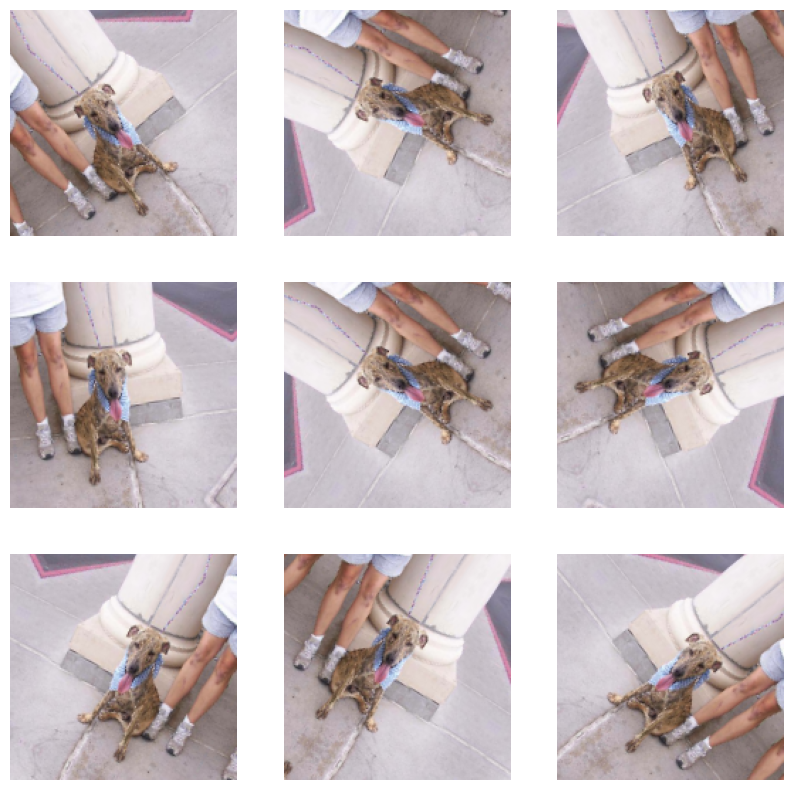

In [10]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [11]:
#get preprocessing layer of base model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


def classification_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = IMG_SIZE + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
   
    #freeze base model
    base_model.trainable = False 

    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False) 
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [12]:
model2 = classification_model(IMG_SIZE, data_augmentation)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8050 - loss: 0.3865 - val_accuracy: 0.9712 - val_loss: 0.0848
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9376 - loss: 0.1477 - val_accuracy: 0.9738 - val_loss: 0.0694
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9455 - loss: 0.1245 - val_accuracy: 0.9764 - val_loss: 0.0703
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9565 - loss: 0.1093 - val_accuracy: 0.9762 - val_loss: 0.0605
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9588 - loss: 0.1062 - val_accuracy: 0.9788 - val_loss: 0.0608
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9589 - loss: 0.1047 - val_accuracy: 0.9772 - val_loss: 0.0575
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9604 - loss: 0.0975 - val_accuracy: 0.9798 - val_loss: 0.0592
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9601 - loss: 0.0927 - val_ac

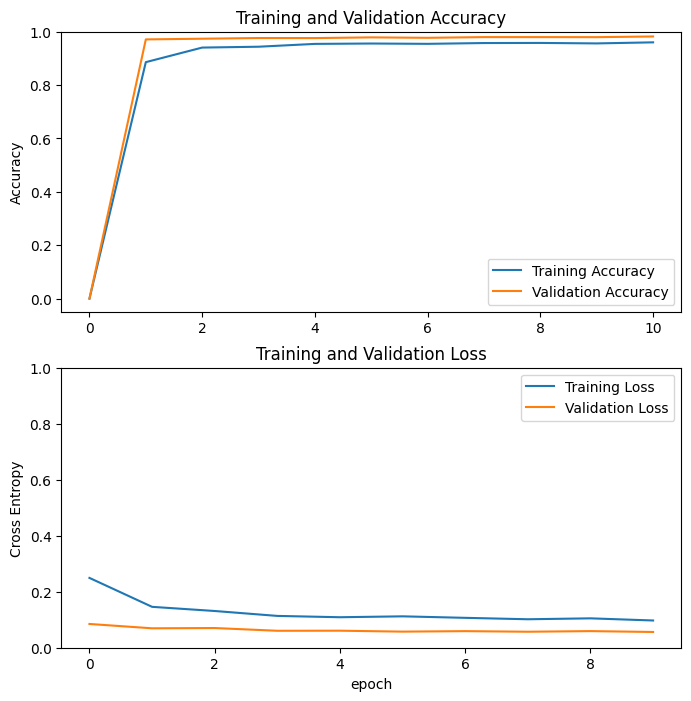

In [15]:
#plot metrics
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

In [17]:
base_model = model2.layers[2]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [18]:
# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate * 0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [19]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.9204 - loss: 0.2174 - val_accuracy: 0.9776 - val_loss: 0.0599
Epoch 11/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9584 - loss: 0.1155 - val_accuracy: 0.9834 - val_loss: 0.0539
Epoch 12/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9617 - loss: 0.0973 - val_accuracy: 0.9800 - val_loss: 0.0714
Epoch 13/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.9681 - loss: 0.0755 - val_accuracy: 0.9832 - val_loss: 0.0602
Epoch 14/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9779 - loss: 0.0541 - val_accuracy: 0.9768 - val_loss: 0.0878
Epoch 15/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9802 - loss: 0.0491 - val_accuracy: 0.9816 - val_loss: 0.0712


In [20]:
test_directory = "/kaggle/working/test1"
files = os.listdir(test_directory)
ids = [os.path.splitext(f)[0] for f in files]
predictions = []
test_dataset = image_dataset_from_directory(test_directory,
                                             shuffle=False,
                                             batch_size=512,
                                             image_size=IMG_SIZE,
                                             label_mode = None,
                                             seed=seed)


for batch in test_dataset:
    prediction = model2.predict(batch)
    prediction = tf.math.sigmoid(tf.squeeze(prediction))
    prediction = tf.cast(prediction > 0.5, tf.int32).numpy()
    predictions.extend(prediction)

Found 12500 files.
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━

In [21]:
print(len(ids))
print(len(predictions))

12500
12500


In [22]:
data = {'id': ids, 'label': predictions}
df = pd.DataFrame(data)
df.to_csv('submission.csv', encoding='utf-8', index=False, header=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


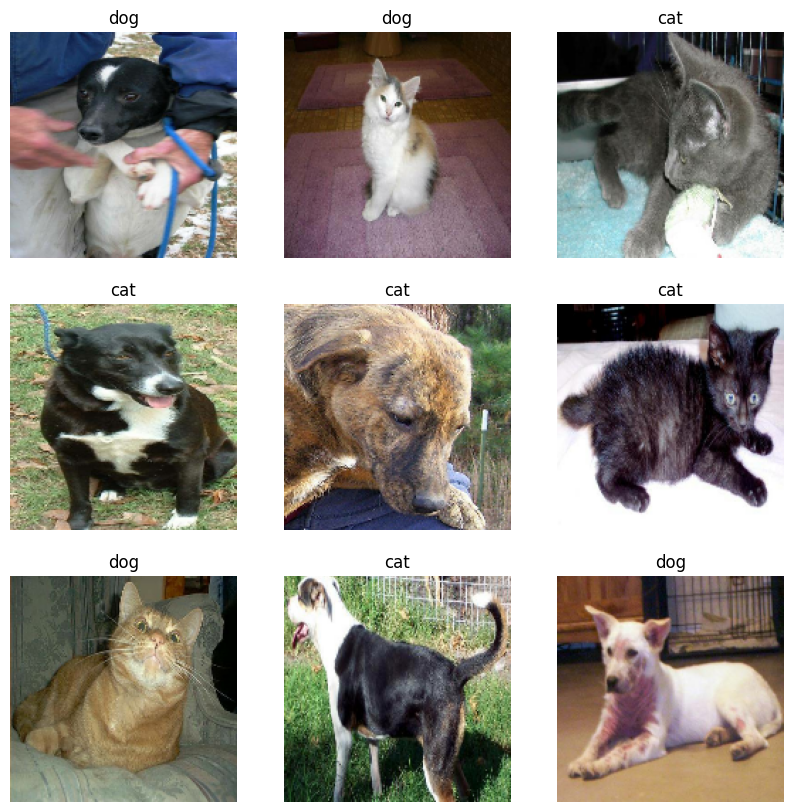

In [23]:
class_names = ['cat', 'dog']
plt.figure(figsize=(10, 10))
for images in test_dataset.take(1):
    prediction = model2.predict(images)
    prediction = tf.math.sigmoid(tf.squeeze(prediction))
    prediction = tf.cast(prediction > 0.5, tf.int32).numpy()
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")